In [1]:
# 導入所有需要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, auc
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import warnings

# 設定視覺化風格與忽略警告
sns.set(style='whitegrid', font='Heiti TC', rc={'axes.unicode_minus':False})
warnings.filterwarnings('ignore')

# 載入資料
try:
    df = pd.read_csv('data0606.csv')
except FileNotFoundError:
    print("錯誤：找不到 'data0606.csv'。請確保檔案與您的 notebook 位於相同目錄下。")
    df = pd.DataFrame() 

if not df.empty:
    print("資料載入成功，資料維度:", df.shape)
    print("目標變數 (target) 分佈:")
    print(df['target'].value_counts())


資料載入成功，資料維度: (1486, 36)
目標變數 (target) 分佈:
target
0    1356
1     130
Name: count, dtype: int64


In [2]:
# --- 1. 資料前處理 ---

# 1.1 轉換 '近六個月上網時間' 為數值 (總分鐘)
def time_to_minutes(time_str):
    try:
        if isinstance(time_str, str) and ':' in time_str:
            h, m = map(int, time_str.split(':'))
            return h * 60 + m
        return np.nan # 對 '未回答/拒答' 或其他格式錯誤的值返回 NaN
    except:
        return np.nan

df['近六個月上網時間_分鐘'] = df['近六個月上網時間'].apply(time_to_minutes)
# 使用中位數填充缺失值
df['近六個月上網時間_分鐘'].fillna(df['近六個月上網時間_分鐘'].median(), inplace=True)
df.drop('近六個月上網時間', axis=1, inplace=True)

# 1.2 定義特徵類型
# 數值特徵
numeric_features = ['近六個月上網時間_分鐘']

# 有序類別特徵與其順序
ordinal_categories = [
    ['減少', '不變', '增加', '未回答/拒答'],  # 疫情後上網狀況
    ['從來沒有', '很少', '有時', '經常', '幾乎總是', '未回答/拒答'],  # 擔心確診情況
    ['從來沒有', '很少', '有時', '經常', '幾乎總是', '未回答/拒答'],  # 擔心居家隔離檢疫
    ['從來沒有', '很少', '有時', '經常', '幾乎總是', '未回答/拒答'],  # 擔心外出確診
    ['從來沒有', '很少', '未回答/拒答'],  # 因疫情失去工作
    ['從來沒有', '很少', '未回答/拒答'],  # 是否居家上班上課
    ['非常不同意', '不同意', '普通', '同意', '非常同意', '未回答/拒答'],  # 難以集中精神
    ['非常不同意', '不同意', '普通', '同意', '非常同意', '未回答/拒答'],  # 生活無聊感
    ['非常不同意', '不同意', '普通', '同意', '非常同意', '未回答/拒答'],  # 課業或工作壓力
    ["12-17歲", "18-19歲", "20-29歲", "30-39歲", "40-49歲", "50-59歲", "60-64歲", "65歲以上"],  # 年齡
    ["國中以下", "高中高職", "專科大學", "研究所以上"],  # 教育程度
    ["沒有", "7 天內", "8-14 天", "15-21 天", "超過21 天", "未回答/拒答"]  # 居家隔離經驗
]

ordinal_features = [
    '疫情後上網狀況',
    '擔心確診情況',
    '擔心居家隔離檢疫，失去他人陪伴情況',
    '擔心外出確診，減少外出情況',
    '因疫情失去工作或工作減量的情況',
    '疫情是否有居家上班或上課的情況',
    '難以集中精神',
    '生活無聊感',
    '課業或工作壓力',
    '年齡',
    '教育程度',
    '有居家隔離或檢疫經驗'
]

categorical_features = [
    '性別',
    '職業',
    '居住地區',
    '是否有染疫的經歷'
] + [col for col in df.columns if col.startswith('疫情後網路活動時間增加的項目_') or col.startswith('無法節制時間的網路活動項目_')]

df['target'] = df['target'].astype(int)

# 1.3 分離特徵 (X) 與目標 (y)
X = df.drop('target', axis=1)
y = df['target']

# 1.4 創建前處理流程 (Pipeline)
# 數值特徵：標準化
numeric_transformer = StandardScaler()

# 有序特徵：順序編碼
ordinal_transformer = OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)

# 無序特徵：獨熱編碼
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 使用 ColumnTransformer 整合所有特徵的處理方式
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=ordinal_categories,
                               handle_unknown='use_encoded_value',
                               unknown_value=-1), ordinal_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop',  # 建議明確 drop，避免 passthrough 的 unnamed columns
    verbose_feature_names_out=True  # ✅ 這樣 feature_names_out 會更穩定
)


# 1.5 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("資料前處理完成。")
print("訓練集維度:", X_train.shape)
print("測試集維度:", X_test.shape)

資料前處理完成。
訓練集維度: (1114, 35)
測試集維度: (372, 35)


Lasso 篩選出的重要特徵：
                             Feature  Coefficient
7                        ord__難以集中精神     0.435146
0                   num__近六個月上網時間_分鐘     0.229911
8                         ord__生活無聊感     0.100044
3             ord__擔心居家隔離檢疫，失去他人陪伴情況     0.017792
33       cat__疫情後網路活動時間增加的項目_看網路社群_0    -0.139964
31     cat__疫情後網路活動時間增加的項目_看社群類的影片_0    -0.142914
12                   ord__有居家隔離或檢疫經驗    -0.154905
29          cat__疫情後網路活動時間增加的項目_追劇_0    -0.177542
39    cat__疫情後網路活動時間增加的項目_網路購物或看商品_0    -0.187491
10                           ord__年齡    -0.199282
5               ord__因疫情失去工作或工作減量的情況    -0.258011
51          cat__無法節制時間的網路活動項目_玩遊戲_0    -0.295649
35         cat__疫情後網路活動時間增加的項目_玩遊戲_0    -0.330512
55  cat__無法節制時間的網路活動項目_網路購物或是看網購商品_0    -0.354753
47      cat__無法節制時間的網路活動項目_看社群類的影片_0    -0.563147
60           cat__無法節制時間的網路活動項目_其他_1    -0.890477


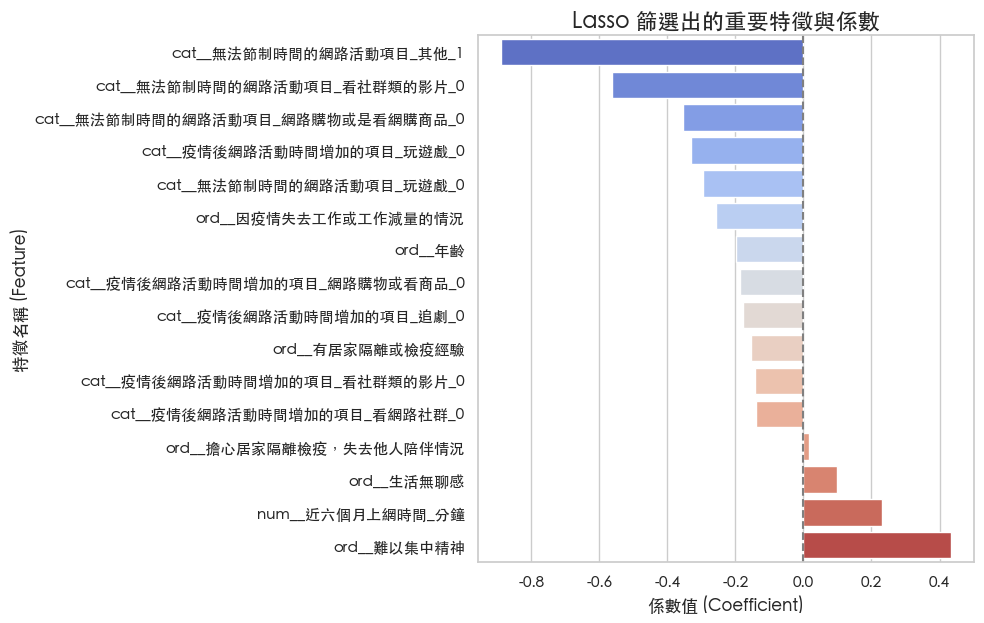


Lasso 總共選出了 16 個重要特徵。


In [3]:
# --- 2. Lasso 特徵選擇 ---

# 創建一個包含前處理和 Lasso 模型的 Pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42))
])

# 訓練 pipeline
lasso_pipeline.fit(X_train, y_train)

# 拿出模型與 ColumnTransformer
model = lasso_pipeline.named_steps['classifier']
preprocessor_fitted = lasso_pipeline.named_steps['preprocessor']

# 取出 ColumnTransformer 處理後的完整特徵名稱（含 prefix）
feature_names = preprocessor_fitted.get_feature_names_out()

# 建立係數表格（與 coef 對齊）
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
})


# 篩選出係數不為零的特徵
important_features = coefficients[coefficients['Coefficient'] != 0]
print("Lasso 篩選出的重要特徵：")
print(important_features.sort_values(by='Coefficient', ascending=False))

plt.rcParams['font.family'] = 'Heiti TC'  ## plt.rcParams['font.family'] = 'Microsoft JhengHei'  # Windows

# 避免負號顯示錯誤
plt.rcParams['axes.unicode_minus'] = False
# 排序特徵（按係數大小）
important_features_sorted = important_features.sort_values(by='Coefficient', ascending=True)

# 設定圖表風格
plt.figure(figsize=(10, max(6, len(important_features_sorted) * 0.4)))
sns.barplot(
    x='Coefficient', y='Feature',
    data=important_features_sorted,
    palette='coolwarm'
)

plt.title('Lasso 篩選出的重要特徵與係數', fontsize=16)
plt.xlabel('係數值 (Coefficient)')
plt.ylabel('特徵名稱 (Feature)')
plt.axvline(x=0, color='gray', linestyle='--')  # 標示係數為 0 的分界
plt.tight_layout()
plt.show()
# 根據 Lasso 結果，我們可以選擇更新我們的 preprocessor，
# 但為了教學的完整性，我們將在後續模型中使用所有特徵，
# 並透過模型內建的特徵重要性來驗證 Lasso 的結果。
# 在實際專案中，你可以在此步驟後只選擇重要特徵進行後續建模。
selected_features_list = important_features['Feature'].tolist()
print(f"\nLasso 總共選出了 {len(selected_features_list)} 個重要特徵。")

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 建立 Ridge pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42))  # C 越小懲罰越強
])

ridge_pipeline.fit(X_train, y_train)

# 取出模型與特徵名稱
ridge_model = ridge_pipeline.named_steps['classifier']
preprocessor_fitted = ridge_pipeline.named_steps['preprocessor']
feature_names = preprocessor_fitted.get_feature_names_out()

# 係數表
ridge_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# 篩選「重要性前 k%」的特徵（你可以調整門檻）
top_k = int(0.3 * len(ridge_coef))  # 取前 30% 的重要變數
selected_features_list = ridge_coef.head(top_k)['Feature'].tolist()

print(f"Ridge 選出前 30% 重要變數，共 {len(selected_features_list)} 個")


Ridge 選出前 30% 重要變數，共 18 個


In [5]:
# --- 將 X_train 與 X_test 進行預處理，並只保留 Lasso 選出的特徵 ---
X_train_transformed = pd.DataFrame(
    preprocessor_fitted.transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_transformed = pd.DataFrame(
    preprocessor_fitted.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

# 篩選出重要特徵
X_train_selected = X_train_transformed[selected_features_list]
X_test_selected = X_test_transformed[selected_features_list]

print(f"篩選後的特徵數：{X_train_selected.shape[1]}")

篩選後的特徵數：18


正在為 XGBoost 進行網格搜索...
Fitting 30 folds for each of 126 candidates, totalling 3780 fits
XGBoost 最佳參數: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 60, 'classifier__subsample': 0.8}
XGBoost 最佳 F1-score (CV): 0.3984


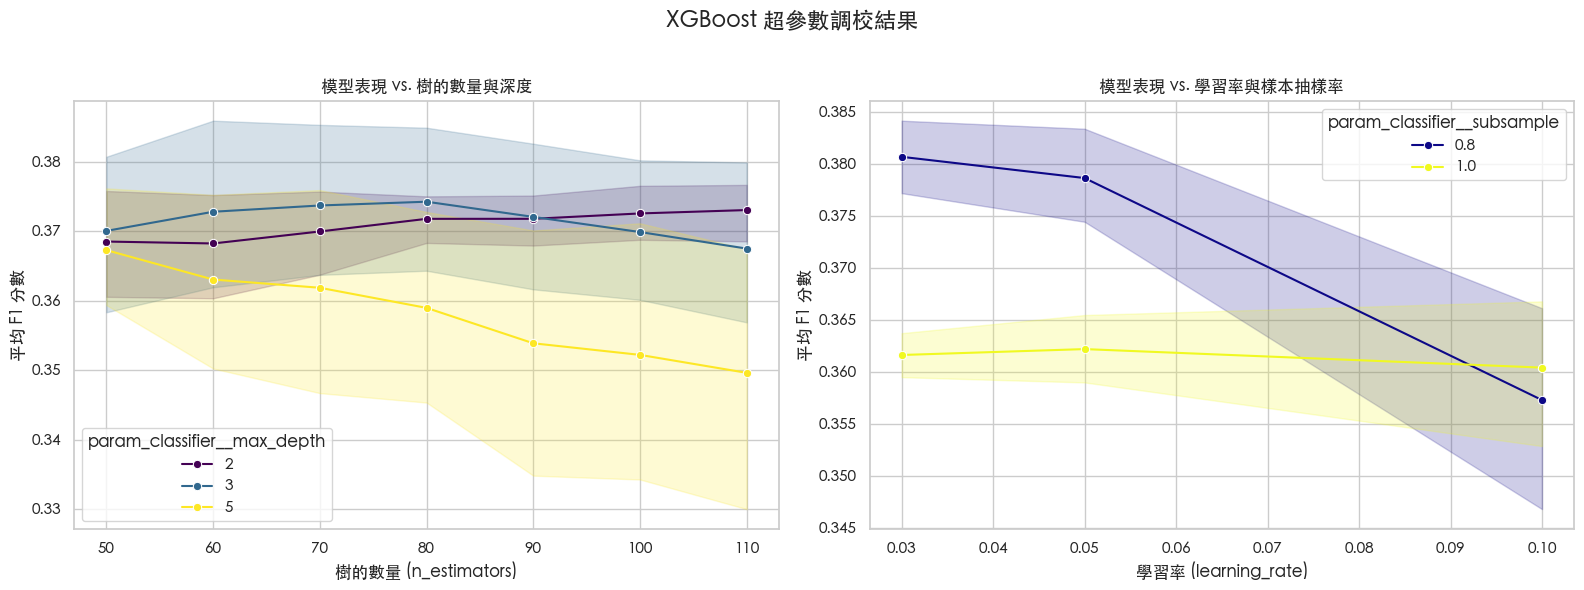


--- XGBoost 在測試集上的表現 ---
              precision    recall  f1-score   support

       無成癮傾向       0.97      0.82      0.88       339
       有成癮傾向       0.27      0.70      0.39        33

    accuracy                           0.81       372
   macro avg       0.62      0.76      0.64       372
weighted avg       0.90      0.81      0.84       372



In [6]:
# --- 3.1 XGBoost 模型 ---

# 計算 scale_pos_weight 以處理不平衡
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 建立 XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, 
                                 random_state=42, scale_pos_weight=scale_pos_weight))
])

# 設定交叉驗證策略
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# 設定超參數網格
param_grid_xgb = {
    'classifier__n_estimators': [50, 60,70,80,90,100,110],
    'classifier__max_depth': [2, 3, 5],
    'classifier__learning_rate': [0.03,0.05, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

# 執行網格搜索
# scoring='f1' 是一個在不平衡資料下比 'accuracy' 更好的綜合指標
grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid_xgb, 
                               n_jobs=-1, cv=cv, scoring='f1', verbose=1)

print("正在為 XGBoost 進行網格搜索...")
grid_search_xgb.fit(X_train, y_train)

# 輸出最佳參數與分數
print(f"XGBoost 最佳參數: {grid_search_xgb.best_params_}")
print(f"XGBoost 最佳 F1-score (CV): {grid_search_xgb.best_score_:.4f}")

# 視覺化超參數搜索結果
cv_results_df = pd.DataFrame(grid_search_xgb.cv_results_)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('XGBoost 超參數調校結果', fontsize=16)

# 繪製 n_estimators 和 max_depth 的影響
sns.lineplot(data=cv_results_df, x='param_classifier__n_estimators', y='mean_test_score', 
             hue='param_classifier__max_depth', ax=axes[0], palette='viridis', marker='o')
axes[0].set_title('模型表現 vs. 樹的數量與深度')
axes[0].set_xlabel('樹的數量 (n_estimators)')
axes[0].set_ylabel('平均 F1 分數')

# 繪製 learning_rate 和 subsample 的影響
sns.lineplot(data=cv_results_df, x='param_classifier__learning_rate', y='mean_test_score', 
             hue='param_classifier__subsample', ax=axes[1], palette='plasma', marker='o')
axes[1].set_title('模型表現 vs. 學習率與樣本抽樣率')
axes[1].set_xlabel('學習率 (learning_rate)')
axes[1].set_ylabel('平均 F1 分數')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 使用最佳模型進行預測
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\n--- XGBoost 在測試集上的表現 ---")
print(classification_report(y_test, y_pred_xgb, target_names=['無成癮傾向', '有成癮傾向']))

正在為 Logistic Regression 進行網格搜索...
Fitting 30 folds for each of 12 candidates, totalling 360 fits
Logistic Regression 最佳參數: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Logistic Regression 最佳 F1-score (CV): 0.3930


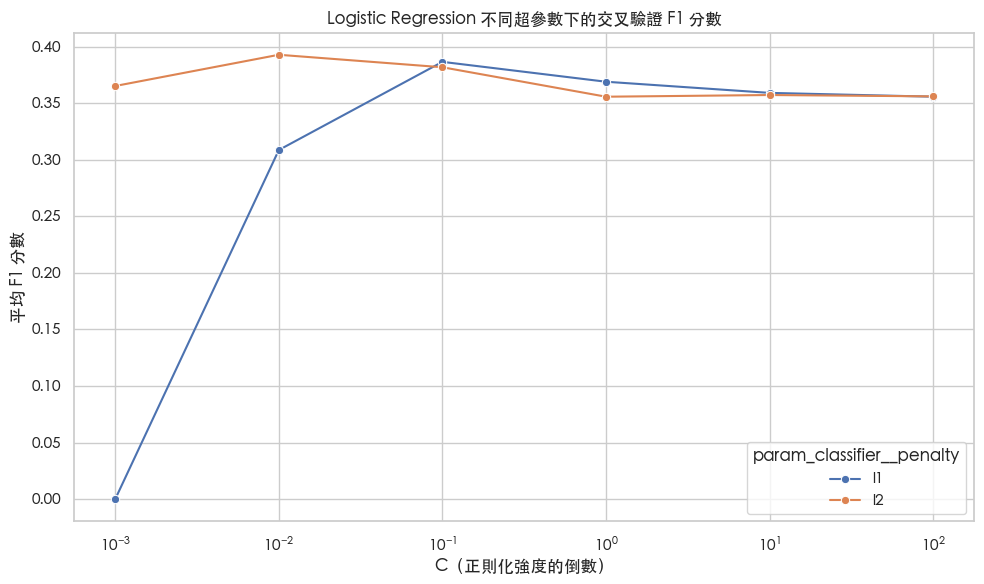


--- Logistic Regression 在測試集上的表現 (class_weight='balanced') ---
              precision    recall  f1-score   support

       無成癮傾向       0.96      0.78      0.86       339
       有成癮傾向       0.23      0.70      0.35        33

    accuracy                           0.77       372
   macro avg       0.60      0.74      0.60       372
weighted avg       0.90      0.77      0.81       372



In [7]:
# --- 3.2 Logistic Regression ---

# 建立 Logistic Regression Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])

# 設定超參數網格
# 'C' 是正規化強度的倒數，penalty 可以是 L1 或 L2
param_grid_lr = {
    'classifier__C': np.logspace(-3, 2, 6), # 涵蓋從 0.001 到 100 的範圍
    'classifier__penalty': ['l1', 'l2']
}

# 執行網格搜索 (這裡我們仍然用 f1 作為主要優化目標，因為它比較均衡)
# 在閾值調整階段，我們才會特別偏向 precision
grid_search_lr = GridSearchCV(estimator=lr_pipeline, param_grid=param_grid_lr, 
                              n_jobs=-1, cv=cv, scoring='f1', verbose=1)

print("正在為 Logistic Regression 進行網格搜索...")
grid_search_lr.fit(X_train, y_train)

# 輸出最佳參數與分數
print(f"Logistic Regression 最佳參數: {grid_search_lr.best_params_}")
print(f"Logistic Regression 最佳 F1-score (CV): {grid_search_lr.best_score_:.4f}")

# 將搜尋結果轉為 DataFrame
cv_results_df = pd.DataFrame(grid_search_lr.cv_results_)

# 將 penalty 類別轉為字串以利繪圖
cv_results_df['param_classifier__penalty'] = cv_results_df['param_classifier__penalty'].astype(str)

# 可視化不同 C 與 penalty 的 F1 分數
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=cv_results_df,
    x='param_classifier__C',
    y='mean_test_score',
    hue='param_classifier__penalty',
    marker='o'
)
plt.xscale('log')  # 對數刻度呈現 C 值
plt.title('Logistic Regression 不同超參數下的交叉驗證 F1 分數')
plt.xlabel('C（正則化強度的倒數）')
plt.ylabel('平均 F1 分數')
plt.grid(True)
plt.tight_layout()
plt.show()

# 使用最佳模型進行預測
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print("\n--- Logistic Regression 在測試集上的表現 (class_weight='balanced') ---")
print(classification_report(y_test, y_pred_lr, target_names=['無成癮傾向', '有成癮傾向']))

正在為 Random Forest 進行網格搜索...
Fitting 30 folds for each of 36 candidates, totalling 1080 fits
Random Forest 最佳參數: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}
Random Forest 最佳 F1-score (CV): 0.4092


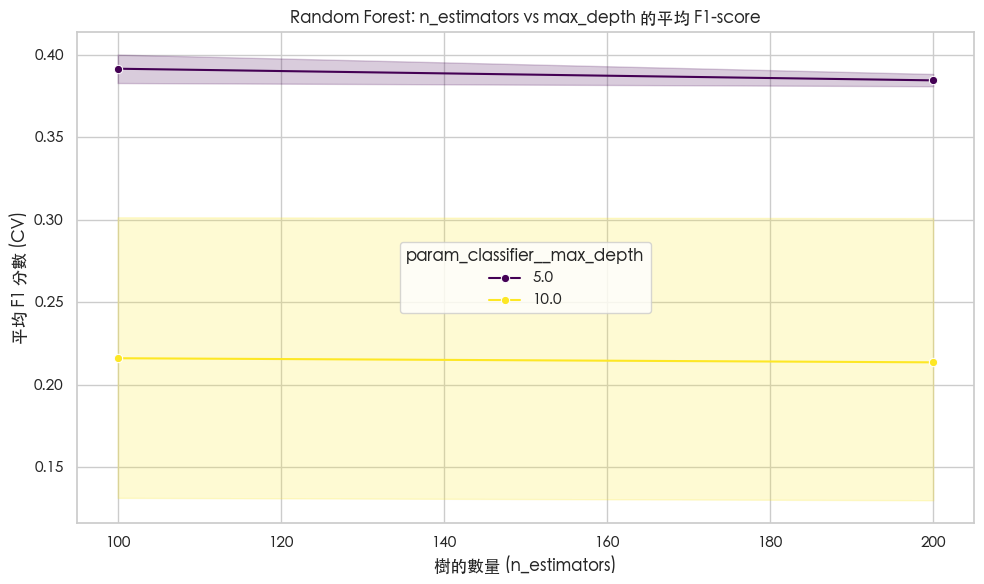


--- Random Forest 在測試集上的表現 (class_weight='balanced') ---
              precision    recall  f1-score   support

       無成癮傾向       0.95      0.85      0.90       339
       有成癮傾向       0.26      0.55      0.36        33

    accuracy                           0.83       372
   macro avg       0.61      0.70      0.63       372
weighted avg       0.89      0.83      0.85       372



In [8]:
# --- 3.3 Random Forest ---

# 建立 Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# 設定超參數網格
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None], # None 表示不限制深度
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# 執行網格搜索
grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, 
                              n_jobs=-1, cv=cv, scoring='f1', verbose=1)

print("正在為 Random Forest 進行網格搜索...")
grid_search_rf.fit(X_train, y_train)

# 輸出最佳參數與分數
print(f"Random Forest 最佳參數: {grid_search_rf.best_params_}")
print(f"Random Forest 最佳 F1-score (CV): {grid_search_rf.best_score_:.4f}")

# 將 GridSearch 結果轉成 DataFrame
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# 範例圖 1：n_estimators 與 max_depth 的 F1-score
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=cv_results_rf,
    x='param_classifier__n_estimators',
    y='mean_test_score',
    hue='param_classifier__max_depth',
    marker='o',
    palette='viridis'
)
plt.title('Random Forest: n_estimators vs max_depth 的平均 F1-score')
plt.xlabel('樹的數量 (n_estimators)')
plt.ylabel('平均 F1 分數 (CV)')
plt.grid(True)
plt.tight_layout()
plt.show()



# 使用最佳模型進行預測
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\n--- Random Forest 在測試集上的表現 (class_weight='balanced') ---")
print(classification_report(y_test, y_pred_rf, target_names=['無成癮傾向', '有成癮傾向']))

In [9]:
# --- 4. 模型集成 ---

# 提取出三個最佳模型
clf1 = grid_search_xgb.best_estimator_
clf2 = grid_search_lr.best_estimator_
clf3 = grid_search_rf.best_estimator_

# 建立軟投票分類器
# 我們可以給予表現更好的模型更高的權重
# 根據 CV 的 F1 分數來分配權重
weights = [grid_search_xgb.best_score_, grid_search_lr.best_score_, grid_search_rf.best_score_]

eclf1 = VotingClassifier(
    estimators=[('xgb', clf1), ('lr', clf2), ('rf', clf3)],
    voting='soft', # 使用軟投票，基於預測機率
    weights=weights # 根據交叉驗證的表現加權
)

# 訓練集成模型
eclf1 = eclf1.fit(X_train, y_train)

# 預測
y_pred_ensemble = eclf1.predict(X_test)
y_proba_ensemble = eclf1.predict_proba(X_test)[:, 1] # 獲取正類的機率

print("\n--- 集成模型 (Voting Classifier) 在測試集上的表現 (預設 0.5 閾值) ---")
print(classification_report(y_test, y_pred_ensemble, target_names=['無成癮傾向', '有成癮傾向']))


--- 集成模型 (Voting Classifier) 在測試集上的表現 (預設 0.5 閾值) ---
              precision    recall  f1-score   support

       無成癮傾向       0.96      0.83      0.89       339
       有成癮傾向       0.27      0.67      0.39        33

    accuracy                           0.81       372
   macro avg       0.62      0.75      0.64       372
weighted avg       0.90      0.81      0.84       372



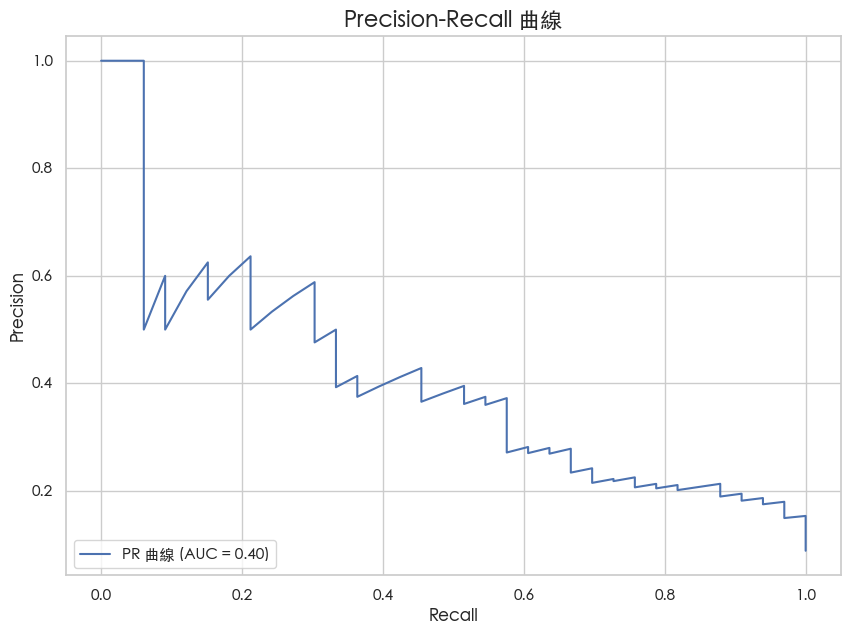

最佳 F1-score: 0.4524
對應的最佳閾值: 0.5825

--- 集成模型最終表現（使用最佳閾值）---
              precision    recall  f1-score   support

       無成癮傾向       0.96      0.91      0.93       339
       有成癮傾向       0.37      0.58      0.45        33

    accuracy                           0.88       372
   macro avg       0.66      0.74      0.69       372
weighted avg       0.90      0.88      0.89       372



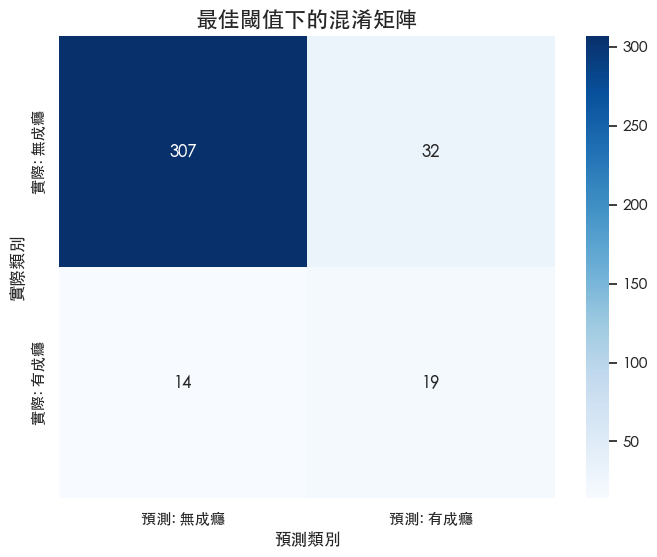

In [10]:
# 1. 繪製 PR 曲線
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_ensemble)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label=f'PR 曲線 (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall 曲線', fontsize=16)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# 2. F1-score 計算（修正 NaN）
precision = precision[:-1]
recall = recall[:-1]

with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores[np.isnan(f1_scores)] = 0

thresholds = thresholds  # 對應無需改動
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"最佳 F1-score: {best_f1_score:.4f}")
print(f"對應的最佳閾值: {best_threshold:.4f}")

# 3. 使用最佳閾值進行預測
y_pred_final = (y_proba_ensemble >= best_threshold).astype(int)
print("\n--- 集成模型最終表現（使用最佳閾值）---")
print(classification_report(y_test, y_pred_final, target_names=['無成癮傾向', '有成癮傾向']))

# 4. 混淆矩陣
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['預測: 無成癮', '預測: 有成癮'],
            yticklabels=['實際: 無成癮', '實際: 有成癮'])
plt.title('最佳閾值下的混淆矩陣', fontsize=16)
plt.xlabel('預測類別')
plt.ylabel('實際類別')
plt.show()


正在計算排列特徵重要性...


<Figure size 1200x800 with 0 Axes>

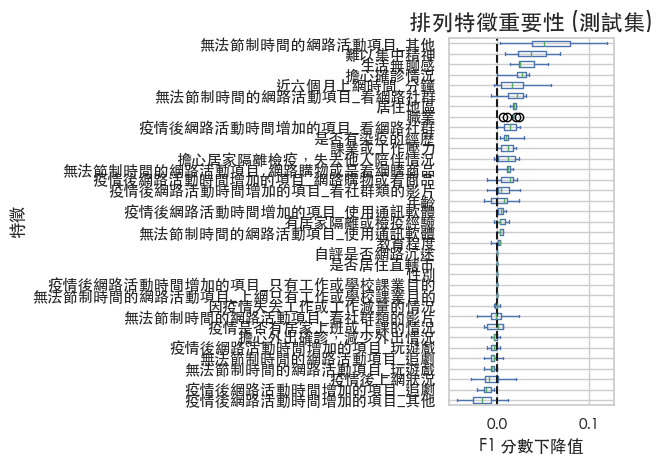

In [11]:
# --- 6.1 排列特徵重要性 ---

# 需要在訓練好的模型上進行計算
# 使用測試集來評估，更能反映模型在未知數據上的泛化能力
print("正在計算排列特徵重要性...")
perm_importance = permutation_importance(
    eclf1, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1'
)

# 獲取原始特徵名稱（因為 preprocessor 包含了 OneHotEncoder）
original_feature_names = X_train.columns.tolist()

# 整理結果
sorted_importances_idx = perm_importance.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

# 繪製圖表
plt.figure(figsize=(12, 8))
importances.plot.box(vert=False, whis=10)
plt.title("排列特徵重要性 (測試集)", fontsize=16)
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("F1 分數下降值")
plt.ylabel("特徵")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

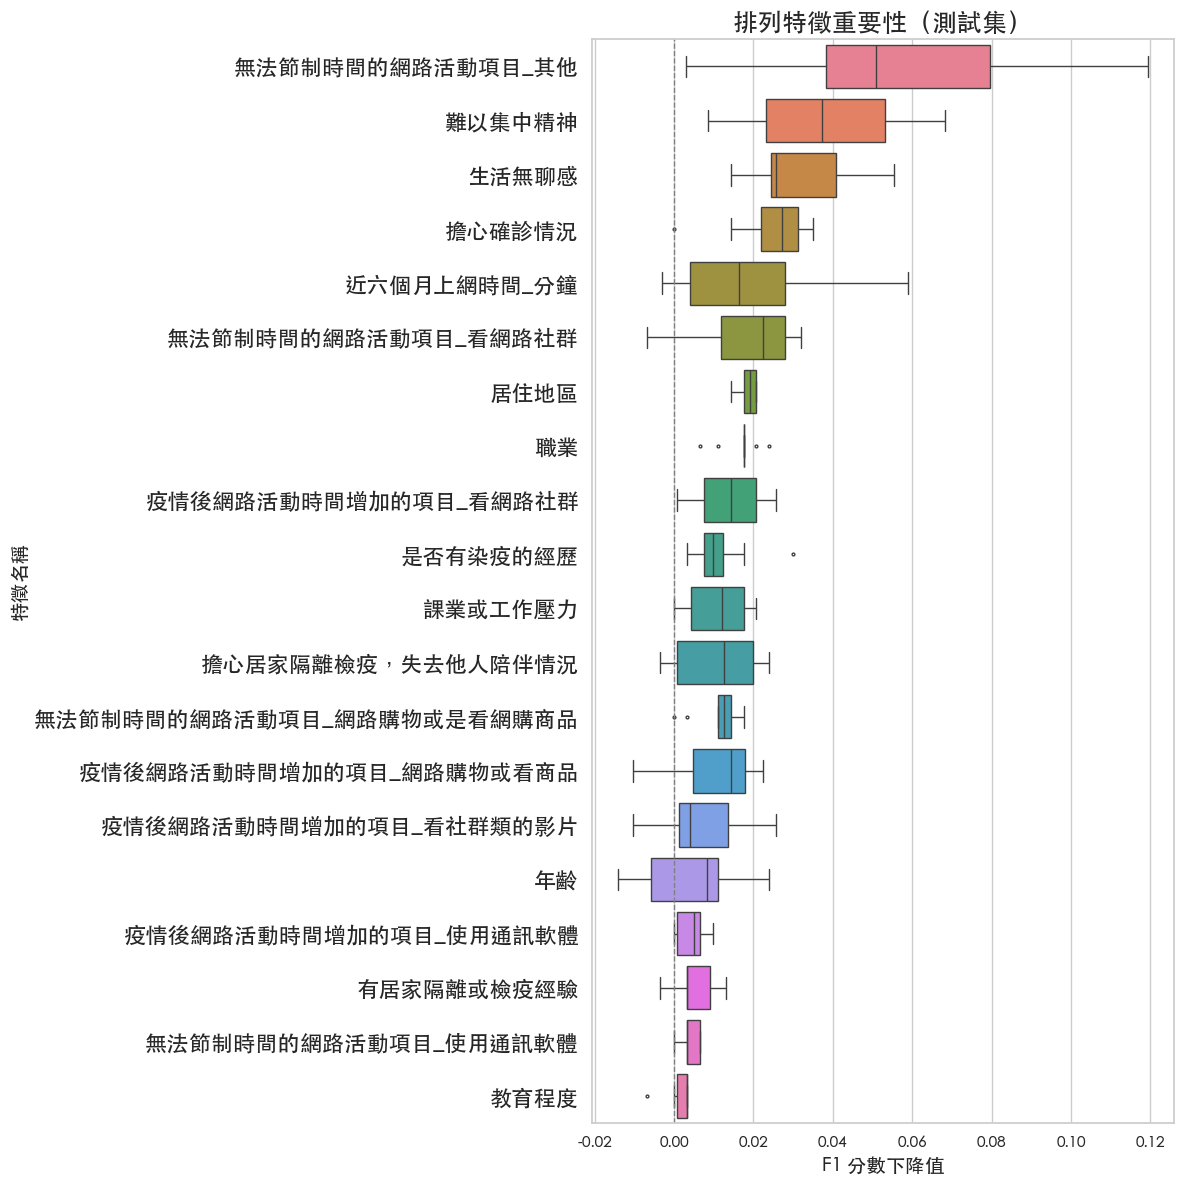

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 排序重要性
sorted_idx = perm_importance.importances_mean.argsort()
feature_names_sorted = X_test.columns[sorted_idx]
importances_df = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=feature_names_sorted,
)

# 可選：只顯示前 N 個最重要特徵（例如前 20 個）
top_n = 20
top_features = feature_names_sorted[::-1][:top_n]  # 由大到小排列

# 選取 top N 的資料
importances_top = importances_df[top_features]

# 設定 Seaborn 主題和顏色
plt.figure(figsize=(12, 0.5 * len(top_features) + 2))  # 根據特徵數自動調整高度

# 繪製橫向 boxplot
sns.boxplot(
    data=importances_top,
    orient="h",
    linewidth=1,
    fliersize=2
)

# 加輔助線與標題
plt.axvline(x=0, color="gray", linestyle="--", linewidth=1)
plt.title("排列特徵重要性（測試集）", fontsize=18)
plt.xlabel("F1 分數下降值", fontsize=14)
plt.ylabel("特徵名稱", fontsize=14)
plt.yticks(fontsize=16)  # 你可以把 12 換成你想要的大小
plt.tight_layout()
plt.show()


In [13]:
# --- 6.2 偏相依圖 ---
# 找到 top_features 在轉換後資料中的索引（支援 OneHot 展開後的所有欄位）


# 再次確認最重要的特徵名稱
top_features = X_test.columns[sorted_importances_idx][-3:] 

print(f"正在為最重要的特徵繪製 PDP (使用修正後的方法): {list(top_features)}")

# 1. 從任何一個基礎 Pipeline 中分離出預處理器 (preprocessor)。
#    因為 clf1, clf2, clf3 的預處理步驟都一樣，所以從誰身上拿都可以。
#    我們從 clf1 (XGBoost Pipeline) 中獲取。
preprocessor = clf1.named_steps['preprocessor']

# 2. 我們要解釋的模型是整個集成模型 eclf1
classifier = eclf1 

# 3. 手動將訓練資料轉換為純數值格式
X_train_transformed = preprocessor.transform(X_train)

# 4. 獲取轉換後所有特徵的名稱列表
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
transformed_feature_names = numeric_features + ordinal_features + list(cat_feature_names)

# 5. 找到 top_features 在轉換後資料中的索引
try:
    top_features_indices = [transformed_feature_names.index(f) for f in top_features]
except ValueError as e:
    print(f"錯誤：特徵 '{e.args[0].split(' is not in list')[0]}' 未在轉換後的特徵列表中找到。請檢查特徵名稱。")
    top_features_indices = []

if top_features_indices:
    # 6. 使用轉換後的資料和特徵索引來繪製 PDP
    fig, axes = plt.subplots(1, len(top_features_indices), figsize=(18, 6), sharey=True)
    fig.suptitle('偏相依圖 (Partial Dependence Plots)', fontsize=16)

    display = PartialDependenceDisplay.from_estimator(
        classifier,
        X_train_transformed,
        features=top_features_indices,
        feature_names=transformed_feature_names,
        kind="average",
        ax=axes
    )

    # 7. 將X軸的數字刻度還原為有意義的文字標籤
    for i, feature_name in enumerate(top_features):
        current_ax = display.axes_.flatten()[i]
        if feature_name in ordinal_features:
            feature_idx_in_ordinal_list = ordinal_features.index(feature_name)
            categories = ordinal_categories[feature_idx_in_ordinal_list]
            current_ax.set_xticks(np.arange(len(categories)))
            current_ax.set_xticklabels(categories, rotation=45, ha='right')
        current_ax.set_xlabel(feature_name, fontsize=12)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

正在為最重要的特徵繪製 PDP (使用修正後的方法): ['生活無聊感', '難以集中精神', '無法節制時間的網路活動項目_其他']
錯誤：特徵 ''無法節制時間的網路活動項目_其他'' 未在轉換後的特徵列表中找到。請檢查特徵名稱。



--- SHAP 解釋 (針對表現最佳的 XGBoost 模型) ---

--- SHAP 全局解釋 ---


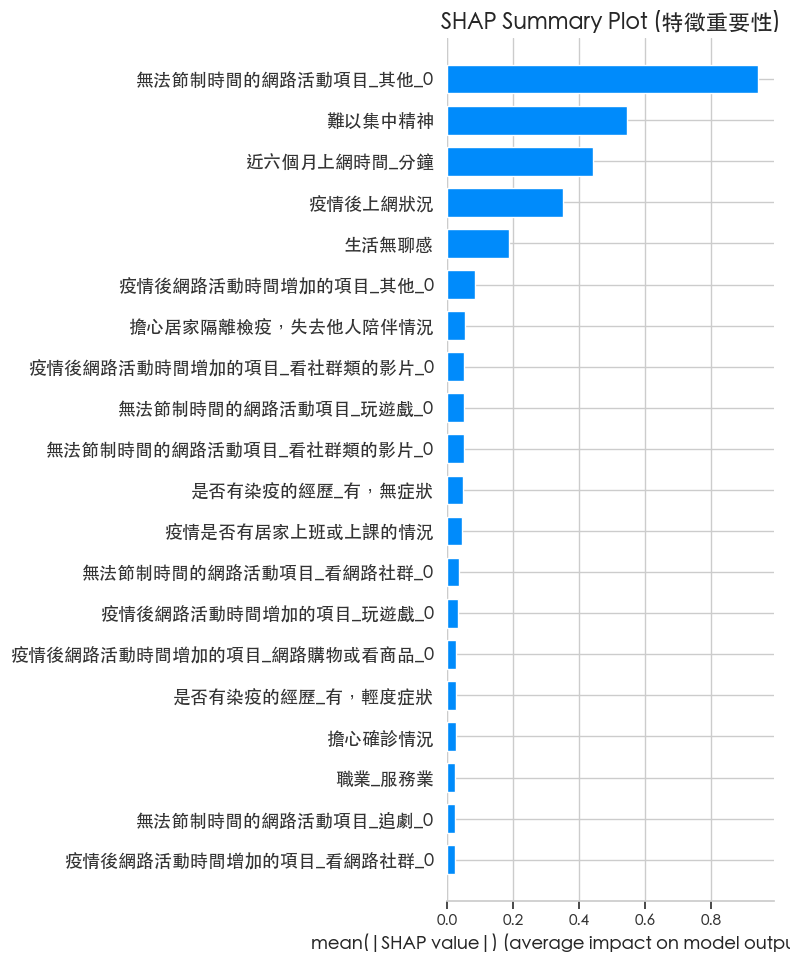

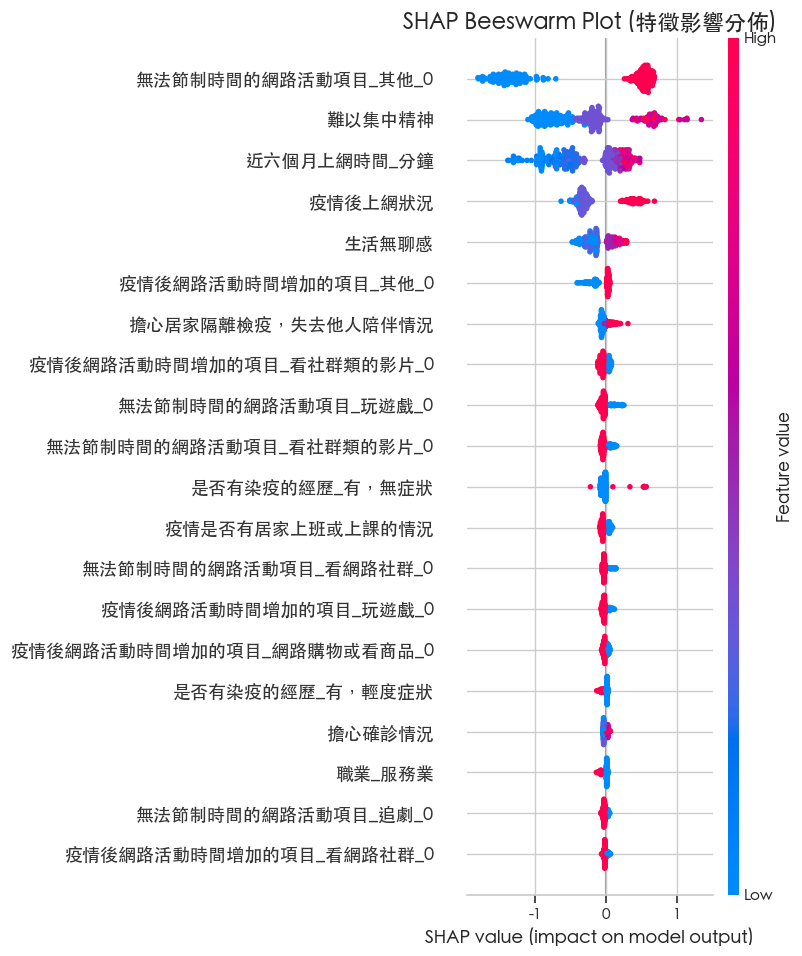


--- SHAP 局部解釋：無法節制時間的網路活動項目_其他_0 ---


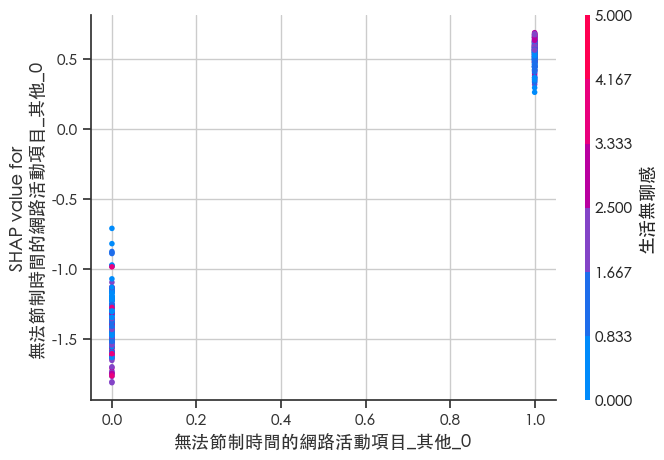

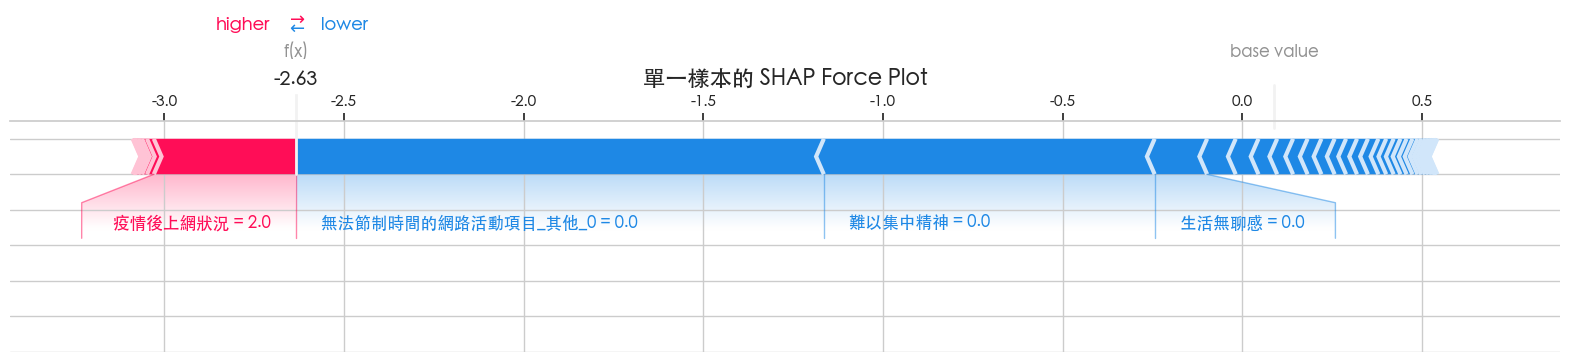

In [14]:
# --- 6.3 SHAP 解釋  ---
# 由於解釋混合型的 VotingClassifier 很複雜，我們專注於解釋其中最強的單一模型 XGBoost

print("\n--- SHAP 解釋 (針對表現最佳的 XGBoost 模型) ---")

# 1. 從最佳 XGBoost pipeline (clf1) 中正確地分離出預處理器和 XGBoost 模型本身
preprocessor_for_shap = clf1.named_steps['preprocessor']
xgb_model_for_shap = clf1.named_steps['classifier']

# 2. 轉換測試集資料以供 SHAP 使用
X_test_transformed = preprocessor_for_shap.transform(X_test)

# 3. 獲取轉換後所有特徵的名稱
transformed_feature_names = numeric_features + ordinal_features + list(preprocessor_for_shap.named_transformers_['cat'].get_feature_names_out(categorical_features))

# 為了讓 SHAP 圖表顯示正確的欄位名稱，將轉換後的 numpy array 包裝成 DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# 4. 建立 TreeExplainer 並計算 SHAP 值
explainer = shap.TreeExplainer(xgb_model_for_shap)
shap_values = explainer(X_test_transformed_df)

# 5. 繪製 SHAP Summary Plot (全局解釋)
print("\n--- SHAP 全局解釋 ---")
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (特徵重要性)", fontsize=16)
plt.show()

shap.summary_plot(shap_values, X_test_transformed_df, show=False)
plt.title("SHAP Beeswarm Plot (特徵影響分佈)", fontsize=16)
plt.show()


# 6. 繪製 SHAP Dependence Plot (單特徵互動解釋)
# 自動選擇最重要的特徵進行繪圖
top_feature_for_dependence = X_test_transformed_df.columns[np.abs(shap_values.values).mean(0).argmax()]
print(f"\n--- SHAP 局部解釋：{top_feature_for_dependence} ---")

shap.dependence_plot(
    top_feature_for_dependence, 
    shap_values.values, 
    X_test_transformed_df, 
    interaction_index="auto"
)

# 7. 繪製 Force Plot (單一樣本解釋)
shap.initjs()
# 解釋測試集中的第一個樣本是如何被 XGBoost 模型預測的
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[0,:], 
    X_test_transformed_df.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.title("單一樣本的 SHAP Force Plot", fontsize=16)
plt.show()

In [23]:
# ----------------------------------------------------------------
# ----------------------------------------------------------------
import joblib
import pandas as pd

# 假設 eclf1 是您訓練好的集成模型

# 1. 儲存預處理器
preprocessor_fitted = eclf1.named_estimators_['xgb'].named_steps['preprocessor']
joblib.dump(preprocessor_fitted, 'preprocessor.joblib')
print("預處理器 'preprocessor.joblib' 已儲存。")

# 2. 儲存不含預處理的 最終模型
# 從集成模型中，提取出 XGBoost pipeline，再從中提取出最終的 'model' 步驟
best_xgb_pipeline = eclf1.named_estimators_['xgb']
final_xgb_model = best_xgb_pipeline.named_steps['classifier']
joblib.dump(final_xgb_model, 'final_model_only.joblib')
print("最終模型 'final_model_only.joblib' 已儲存。")

# 3. 儲存您已經切分好的訓練和測試資料 作為另一個檔案的檢定分析（因為環境設定不同所以開啟不同的notebook使用)
X_train.to_csv('X_train_data.csv', index=False)
X_test.to_csv('X_test_data.csv', index=False)
y_train.to_csv('y_train_data.csv', index=False)
y_test.to_csv('y_test_data.csv', index=False)
print("\n資料集 'X_train_data.csv', 'X_test_data.csv', 'y_train_data.csv', 'y_test_data.csv' 已儲存。")

預處理器 'preprocessor.joblib' 已儲存。
最終模型 'final_model_only.joblib' 已儲存。

資料集 'X_train_data.csv', 'X_test_data.csv', 'y_train_data.csv', 'y_test_data.csv' 已儲存。
